In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pickle

In [2]:
import nltk
from nltk.util import pr
stemmer = nltk.SnowballStemmer('english')
from nltk.corpus import stopwords
import string
stopword = set(stopwords.words('english'))

In [3]:
df = pd.read_csv('./Depression_Text.csv')
df.head()

,text,class,scale
0,Ex Wife Threatening SuicideRecently I left my ...,depressed,4.0
1,i need helpjust help me im crying so hard,depressed,2.0
2,Honetly idkI dont know what im even doing here...,depressed,5.0
3,[Trigger warning] Excuse for self inflicted bu...,depressed,4.0
4,It ends tonight.I can’t do it anymore. \nI quit.,depressed,4.0


In [4]:
df = df[['text','scale']]

In [5]:
df = df.sample(frac = 1)

In [6]:
df.head()

,text,scale
471,if you still remember my username please read ...,5.0
2947,I need some feedback on a situationI once told...,4.0
7533,Lost one of my employees to depressed.I realiz...,5.0
2144,"Goodbye, reddit, i buy the ropes tomorrowI fig...",4.0
6934,Feeling like a failureMy life is miserable. I ...,5.0


In [7]:
df.groupby('scale').describe()

text                                                               
      count unique                                                top freq
scale                                                                     
0.0    1402   1398  after 2 month i bought new tcl 32 inch led tv ...    3
1.0    1522   1522  Day 1 of mocking people who mock others. #XD\n...    1
2.0     820    820  Spiraling and no one to helpI find myself ment...    1
3.0    1078   1078  I want to kill myself so badly but i have an e...    1
4.0     883    883  I need some feedback on a situationI once told...    1
5.0    2087   2087  if you still remember my username please read ...    1
6.0       4      4  Keep failing at suicideI keep failing at suici...    1

In [8]:
df = df.replace(6,5)

In [9]:
df =  df.fillna(0)

In [10]:
df.groupby('scale').describe()

text                                                               
      count unique                                                top freq
scale                                                                     
0.0    1404   1400  after 2 month i bought new tcl 32 inch led tv ...    3
1.0    1522   1522  Day 1 of mocking people who mock others. #XD\n...    1
2.0     820    820  Spiraling and no one to helpI find myself ment...    1
3.0    1078   1078  I want to kill myself so badly but i have an e...    1
4.0     883    883  I need some feedback on a situationI once told...    1
5.0    2091   2091  if you still remember my username please read ...    1

In [11]:
import re

In [12]:
def clean(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]','',text)
  text = re.sub('https?://\S+|www\.\S+','',text)
  text = re.sub('<.*?>+','',text)
  text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
  text = re.sub('\n','',text)
  text = re.sub('\w*\d\w*','',text)
  text = [word for word in text.split(' ') if word not in stopword] 
  text = " ".join(text)
  text = [stemmer.stem(word) for word in text.split(' ')]
  text = " ".join(text)
  return text

df['text'] = df["text"].apply(clean)
print(df.head())

                                                   text  scale
471   still rememb usernam pleas read thiskept someo...    5.0
2947  need feedback situationi told close friend wou...    4.0
7533  lost one employe depressedi realiz depress ber...    5.0
2144  goodby reddit buy rope tomorrowi figur id lost...    4.0
6934  feel like failuremi life miser sometim groan f...    5.0


In [13]:
x = np.array(df['text'])
y = np.array(df['scale'])

cv = CountVectorizer()
x = cv.fit_transform(x)
X_train , X_test , y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10,criterion = 'entropy',random_state = 0)
classifier.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [14]:
y_pred = classifier.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score , f1_score , precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay , RocCurveDisplay 
def get_metrics(y_test,y_predicted):
    accuracy = accuracy_score(y_test,y_predicted)
    precision = precision_score(y_test,y_predicted,average="weighted")
    recall = recall_score(y_test,y_predicted,average="weighted")
    f1 = f1_score(y_test,y_predicted,average="weighted")
    return accuracy , precision,recall,f1
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test,name="Actual"),pd.Series(y_pred,name="Predicted")))
acuracy,precision,recall,f1 = get_metrics(y_test,y_pred)
print("accuracy = %.3f \nprecision =%.3f \nrecall =%.3f \nf1 =%.3f" % (acuracy,precision,recall,f1))

Confusion matrix

Predicted  0.0  1.0  2.0  3.0  4.0  5.0
Actual                                 
0.0        314   87    2    2    4   23
1.0        125  230    7   18    7   59
2.0         13   31   20   33   17  124
3.0         18   52   25   45   20  164
4.0         14   36   26   24   20  129
5.0         43  105   52   97   46  308
accuracy = 0.400 
precision =0.360 
recall =0.400 
f1 =0.373


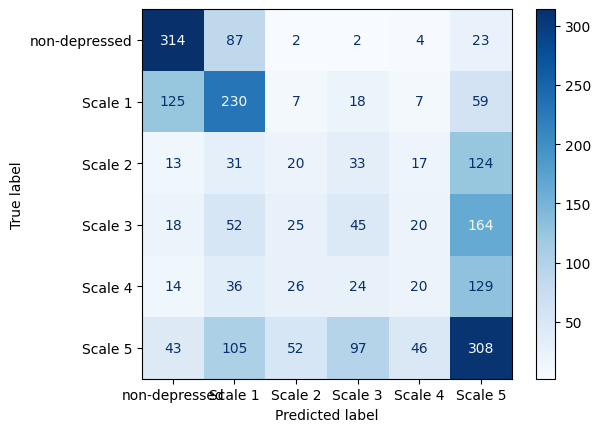

In [16]:
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels=['non-depressed','Scale 1' , 'Scale 2', 'Scale 3' , 'Scale 4' , 'Scale 5'])
cmp = cmp.plot(cmap="Blues")
plt.show()

In [17]:
import gradio as gr
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [18]:
labels = ['non-depressed','Scale 1' , 'Scale 2', 'Scale 3' , 'Scale 4' , 'Scale 5']

tweets = []
limit = 1

def getPrediction(username):
        for tweet in sntwitter.TwitterSearchScraper(username).get_items():
                if len(tweets) == limit:
                        break
                else:
                        tweets.append(tweet.content)
                        
        Text = tweets[0]
        Text = clean(Text)
        X = cv.transform([Text])
        prediction = classifier.predict_proba(X)
        return {labels[0]:prediction[0][0] ,labels[1]:prediction[0][1] ,labels[2]:prediction[0][2] ,labels[3]:prediction[0][3] ,labels[4]:prediction[0][4] ,labels[5]:prediction[0][5]}

        


In [19]:
iface = gr.Interface(fn=getPrediction,inputs = "text",outputs="label",title="Depression Classification with twitter user id")
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860


C:\Users\Acer\AppData\Local\Temp\ipykernel_5444\3310594325.py:11: FutureWarning: content is deprecated, use rawContent instead
  tweets.append(tweet.content)


KeyboardInterrupt: 